In [1]:
# Configurations related to Kafka connector 
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.0 pyspark-shell'



In [2]:
from pyspark.sql import *
from pyspark.sql.functions import json_tuple,from_json,explode,col
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.sql.types import StructType,FloatType, StructField, StringType,TimestampType
import json
import pandas as pd
import time

spark = SparkSession \
    .builder \
    .appName("SparkStreaming") \
    .getOrCreate()

In [3]:
spark.conf.set("spark.sql.shuffle.partitions", 10)

In [4]:
# Construct a streaming DataFrame that reads from topic1
socketDF = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("subscribe", "incoming_tweets") \
  .load()

In [5]:
schema = StructType(
    [
        StructField("created_at",TimestampType(), True),\
        StructField("text",StringType(), True),\
        StructField("id",StringType(), True),\
        StructField("sentimentScore",FloatType(), True),\
        StructField("sentiment",StringType(), True)
    ]
)

In [6]:
json = socketDF.selectExpr("CAST(value AS STRING) as data")

json = json.withColumn("data",from_json(json.data,schema))\
    
data = json.select(col('data.*'))

In [16]:
query=data.writeStream\
    .outputMode("append")\
    .format("memory")\
    .queryName("data")\
    .start()

In [17]:
avgSentiment = spark.sql("""
SELECT avg(sentimentScore), date_format(window(from_utc_timestamp(created_at,'cst'), '1 minutes').start, 'YYYY-MM-dd HH:mm:ss') as time 
                              FROM data
                              GROUP BY window(from_utc_timestamp(created_at,'cst'), '1 minutes')
                              ORDER BY time 
""")

In [18]:
totalCounts = spark.sql("""
SELECT count(*) as count,count(distinct id) as idCount FROM data
""")

In [20]:
totalCounts.show()

+-----+-------+
|count|idCount|
+-----+-------+
|  100|    100|
+-----+-------+



In [21]:
sentimentCounts = spark.sql("""
SELECT count(*) as count,sentiment, date_format(window(from_utc_timestamp(created_at,'cst'), '1 minutes').start, 'YYYY-MM-dd HH:mm:ss') as time 
                              FROM data
                              GROUP BY window(from_utc_timestamp(created_at,'cst'), '1 minutes'),sentiment
                              ORDER BY time desc
""")

In [27]:
from IPython.display import clear_output

starttime=time.time()
while True:
    sentimentCounts.show()
    avgSentiment.show()
    time.sleep(5.0- ((time.time() - starttime) % 5.0))
    clear_output()
    


+-----+---------+-------------------+
|count|sentiment|               time|
+-----+---------+-------------------+
|   55| negative|2019-02-16 06:59:00|
|   17| positive|2019-02-16 06:59:00|
|   28|  neutral|2019-02-16 06:59:00|
+-----+---------+-------------------+

+-------------------+-------------------+
|avg(sentimentScore)|               time|
+-------------------+-------------------+
|              -1.58|2019-02-16 06:59:00|
+-------------------+-------------------+



KeyboardInterrupt: 

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

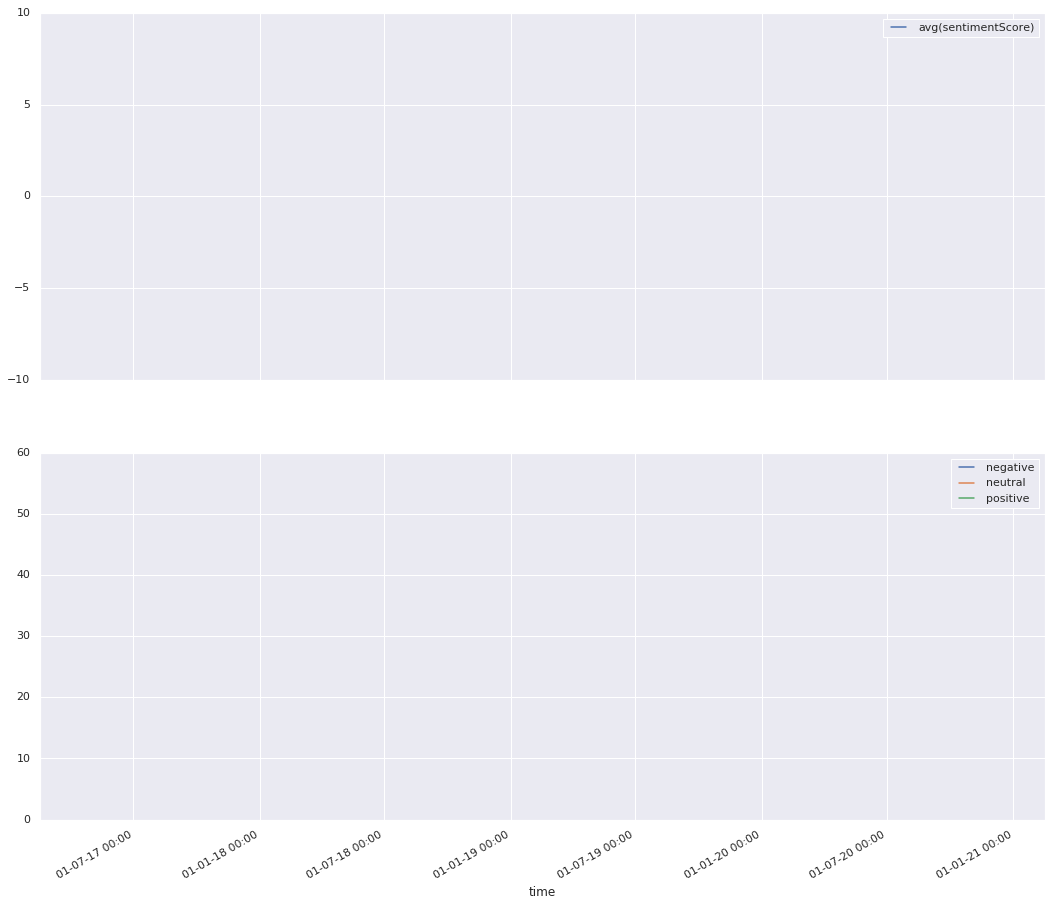

KeyboardInterrupt: 

In [28]:
fig, ax = plt.subplots(2,1,figsize=(18, 16))
xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')


while True:
    ax[0].clear()
    ax[1].clear()
    df = avgSentiment.toPandas()
    df['time'] = pd.to_datetime(df['time']) - pd.Timedelta('06:00:00')

    df.set_index('time').plot(ax=ax[0])
    df2 = sentimentCounts.toPandas()
    df2['time'] = pd.to_datetime(df2['time']) - pd.Timedelta('06:00:00')
    
    for key,grp in df2.groupby('sentiment'):
        grp.plot(ax=ax[1],x='time',y='count', label=key)
    
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    ax[0].set_ylim([-10, 10])
    ax[1].set_ylim([0,5+ax[1].get_ylim()[1]])
    
    ax[0].set_xlim(right = 1+ax[0].get_xlim()[1])
    ax[1].set_xlim(right = 1+ax[1].get_xlim()[1])
    
    fig.autofmt_xdate()
    
    ax[0].xaxis.set_major_formatter(xfmt)
    ax[1].xaxis.set_major_formatter(xfmt)
    
    fig.canvas.draw()
    plt.pause(0.05)
    fig.canvas.flush_events()
    
plt.show()

In [15]:
query.stop()

In [ ]:
sentimentCounts.toPandas()

In [ ]:
sentimentCounts.show()